# Import Important Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import pickle
from matplotlib.ticker import FixedLocator

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
import joblib

In [4]:
from sklearn.model_selection import RandomizedSearchCV

# Important Functions

In [5]:
def model_evaluation(y_test, y_pred):
    """
    Evaluate the model's predictions using confusion matrix, classification report,
    and additional performance metrics such as F1-score, TPR, FPR, and accuracy.
    """
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['AI', 'Human'])
    disp.plot(cmap='viridis')
    plt.title("Confusion Matrix")
    plt.show()

    # Print the classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Extract components of the confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Safeguard against division by zero for rates
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    print("\nAdditional Metrics:")
    print(f"True Positive Rate (TPR, Sensitivity): {tpr:.2f}")
    print(f"True Negative Rate (TNR, Specificity): {tnr:.2f}")
    print(f"False Positive Rate (FPR): {fpr:.2f}")
    print(f"False Negative Rate (FNR): {fnr:.2f}")

    # Calculate total number of mistakes (false predictions)
    actual_mistakes = fp + fn
    error_rate = actual_mistakes / len(y_pred)

    print("\nTotal Number of Mistakes:", actual_mistakes)
    print(f"Error Rate: {error_rate:.2f}")


In [6]:
def evaluation(X_train, ground_truth_y_train, X_test, ground_truth_y_test, model):
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print("TRAINING DATASET")
    model_evaluation(ground_truth_y_train, y_pred_train)
    print("\nTESTING DATASET")
    model_evaluation(ground_truth_y_test, y_pred_test)

In [28]:
def count_plot(dataset, save_fig = None):

    # Define the label mapping with integer keys
    label_mapping = {1: 'Human', 0: 'AI'}
    
    # Create the countplot
    ax = sns.countplot(x='label', data=dataset)
    
    # Set fixed ticks and tick labels based on the mapping
    ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
    ax.set_xticklabels([label_mapping[int(label.get_text())] for label in ax.get_xticklabels()])
    
    # Annotate each bar with the count
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',  # The count value
            (p.get_x() + p.get_width() / 2, p.get_height()),  # Position of the text
            ha='center',
            va='bottom'
        )
    ax.set_xlabel('Category')  
    ax.set_ylabel('Count')  

    # save plot
    if save_fig:
        plt.savefig(save_fig)
    
    # Show the plot
    plt.show()

# Loading Dataset

In [29]:
def get_dataset_df(human_dataset_path, ai_dataset_path):
    dataset_paths = [human_dataset_path, ai_dataset_path]
    result_df = pd.DataFrame()
    
    for dataset_path in dataset_paths:

        label = 0 if dataset_path.split('\\')[-1] == 'AI' else 1 ## 0 for AI generated text and 1 for human generated text
        
        csv_files = [os.path.join(dataset_path, file_name) for file_name in os.listdir(dataset_path) 
                if file_name.endswith(".csv")]
        
        for csv_file in csv_files:
            data = pd.read_csv(csv_file)
            data['label'] = label
            result_df = pd.concat([result_df, data], ignore_index=True)
    result_df = result_df.drop(columns = ['uid'])
    result_df = result_df.drop_duplicates()
    result_df = result_df.sample(frac=1).reset_index(drop=True)
            
    return result_df

In [30]:
ai_dataset_path = r"Dataset\AI"
human_dataset_path = r"Dataset\Human"
dataset = get_dataset_df(human_dataset_path, ai_dataset_path)

In [31]:
dataset.shape

(58537, 2)

In [32]:
dataset.head()

,text,label
0,"Crossrail, London's new east-west rail network...",0
1,Hillary Clinton's run for President has made g...,0
2,Modern emperor penguins are certainly statuesq...,1
3,He may not be as crass and bombastic as Donald...,1
4,MANAGUA--When David and Yandelis left Haiti to...,1


In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58537 entries, 0 to 58536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    58537 non-null  object
 1   label   58537 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 914.8+ KB


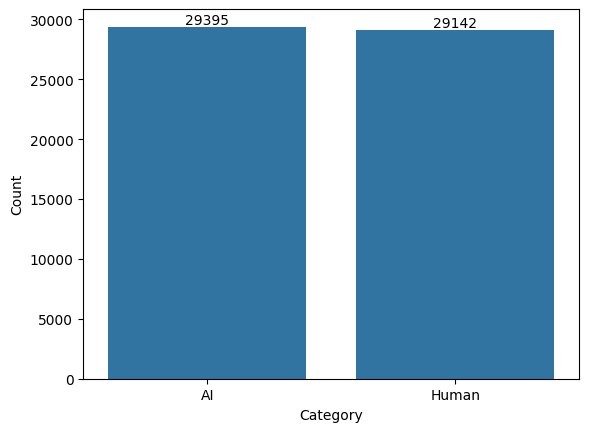

In [35]:
count_plot(dataset, 'data_distribution.jpg')

# Selecting smaples with equal class

In [23]:
dataset.shape

(58537, 2)

In [24]:
def sampling_the_dataset(dataset, num_samples, random_state=42):
    class_0_samples = num_samples//2
    class_1_samples = num_samples - class_0_samples
    
    dataset_0 = dataset[dataset['label'] == 0]
    sampled_dataset_0 = dataset_0.sample(class_0_samples, random_state=random_state)
    
    dataset_1 = dataset[dataset['label'] == 1]
    sampled_dataset_1 = dataset_1.sample(class_1_samples, random_state=random_state)

    combined_dataset = pd.concat([sampled_dataset_0, sampled_dataset_1], axis=0, ignore_index=True)

    shuffled_dataset = combined_dataset.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return shuffled_dataset

In [25]:
dataset_25000 = sampling_the_dataset(dataset,25000)

In [26]:
dataset_25000.shape

(25000, 2)

In [27]:
dataset_25000.head()

,text,label
0,"C.J. Minster, Lisa Savage and Alli McCracken (...",0
1,An ultimatum that was issued by several Arab s...,1
2,As America imports less energy from the region...,0
3,It is impossible not to notice the music in th...,1
4,This is a successful week for adaptations of S...,1


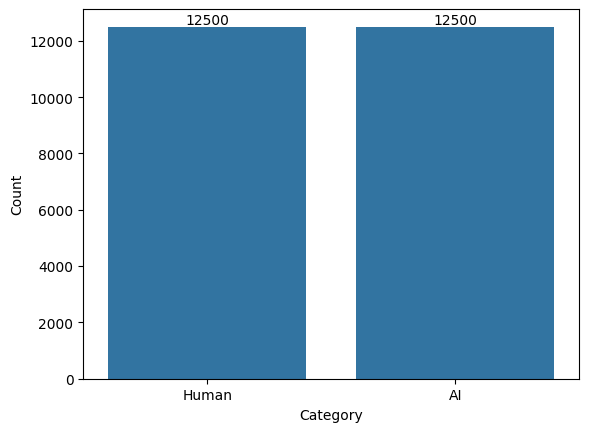

In [28]:
count_plot(dataset_25000)

# Scaling and PCA

In [12]:
embedded_dataset = pd.read_csv("Dataset/sentence_embedding_dataset.csv")

In [13]:
embedded_dataset.shape

(58537, 385)

In [14]:
embedded_dataset = embedded_dataset.iloc[:1000, :]

In [15]:
embedded_dataset.shape

(1000, 385)

In [16]:
X = embedded_dataset.drop('label', axis=1)
y = embedded_dataset['label']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [18]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [19]:
from sklearn.pipeline import Pipeline

In [83]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('pca', PCA())   # Apply PCA with 2 components
])

In [84]:
pipeline.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [85]:
X_train_transformed = pipeline.transform(X_train)

In [86]:
X_train_transformed.shape

(49756, 384)

In [87]:
explained_variance_ratio = pipeline['pca'].explained_variance_ratio_

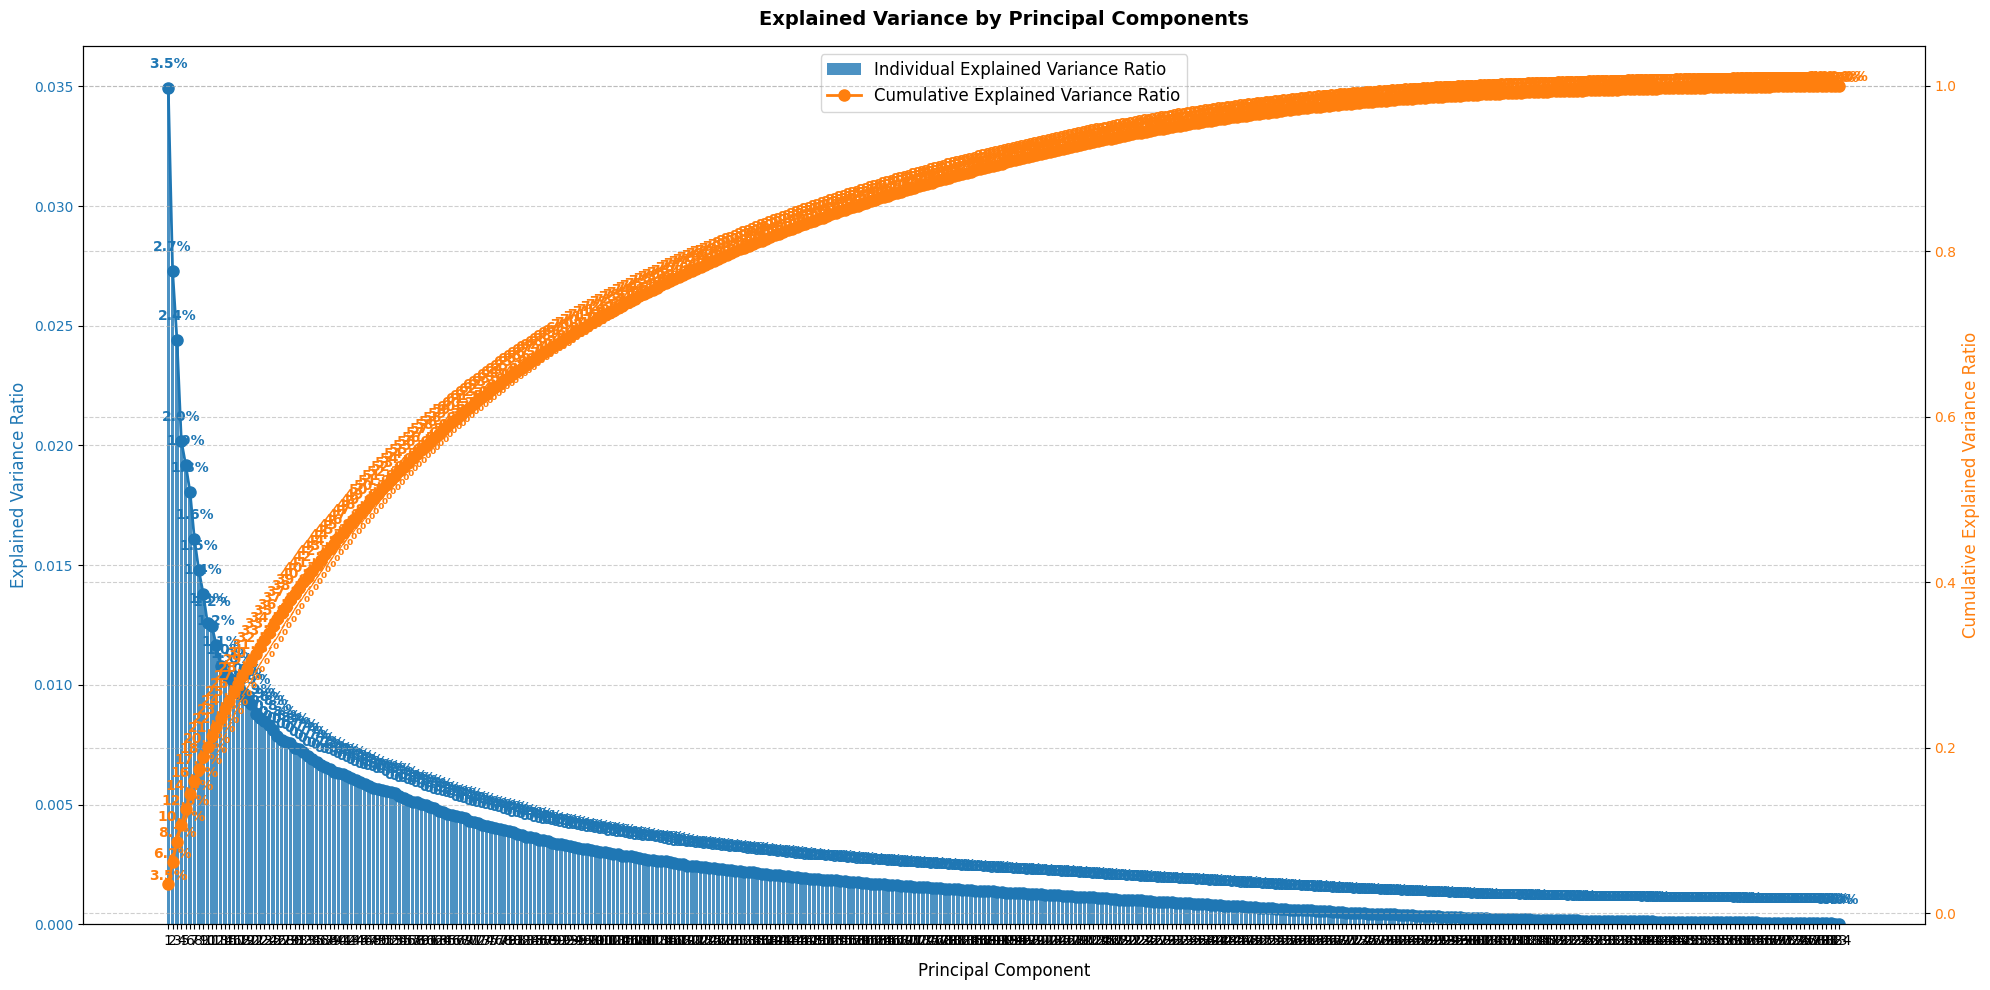

In [88]:
plot_explained_variance(explained_variance_ratio, figsize = (20, 10), savefig=True)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

def plot_explained_variance(
    explained_variance_ratio: List[float],
    figsize: Tuple[float, float] = (11, 8),
    savefig: bool = False,
    output_file: str = "explained_variance_plot.png"
) -> None:
    """
    Plots the explained variance ratio and cumulative explained variance ratio for PCA components.

    Args:
        explained_variance_ratio (List[float]): List of explained variance ratios for each principal component.
        figsize (Tuple[float, float]): Size of the figure in inches (width, height). Defaults to (11, 8).
        savefig (bool): Whether to save the plot as a file. Defaults to False.
        output_file (str): File path to save the generated plot if savefig is True. Defaults to 'explained_variance_plot.png'.

    Returns:
        None
    """
    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    # Create the explained variance plot with two axes
    fig, ax1 = plt.subplots(figsize=figsize)

    # Colors
    bar_color = '#1f77b4'  # Blue for bar and line
    line_color = '#ff7f0e'  # Orange for the cumulative line

    # Explained variance ratio on the primary y-axis (left)
    ax1.bar(
        range(1, len(explained_variance_ratio) + 1),
        explained_variance_ratio,
        alpha=0.8,
        color=bar_color,
        label="Individual Explained Variance Ratio"
    )
    ax1.plot(
        range(1, len(explained_variance_ratio) + 1),
        explained_variance_ratio,
        marker="o",
        markersize=8,
        color=bar_color,
        linewidth=2
    )
    ax1.set_xlabel("Principal Component", fontsize=12, labelpad=10)
    ax1.set_ylabel("Explained Variance Ratio", color=bar_color, fontsize=12)
    ax1.tick_params(axis="y", labelcolor=bar_color)
    ax1.grid(axis="y", linestyle="--", alpha=0.6)

    # Cumulative explained variance on the secondary y-axis (right)
    ax2 = ax1.twinx()  # Share the x-axis
    ax2.plot(
        range(1, len(cumulative_explained_variance) + 1),
        cumulative_explained_variance,
        marker="o",
        markersize=8,
        color=line_color,
        label="Cumulative Explained Variance Ratio",
        linewidth=2
    )
    ax2.set_ylabel("Cumulative Explained Variance Ratio", color=line_color, fontsize=12)
    ax2.tick_params(axis="y", labelcolor=line_color)
    ax2.grid(axis="y", linestyle="--", alpha=0.6)

    # Add percentage labels on bar and line points
    for i, ev in enumerate(explained_variance_ratio):
        ax1.text(i + 1, ev + 0.001, f"{ev:.1%}", ha="center", va="center", color=bar_color, fontsize=10, weight="bold")
    for i, cev in enumerate(cumulative_explained_variance):
        ax2.text(i + 1, cev + 0.01, f"{cev:.1%}", ha="center", va="center", color=line_color, fontsize=10, weight="bold")

    # Title and legend
    plt.title("Explained Variance by Principal Components", fontsize=14, weight="bold", pad=15)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center", fontsize=12)

    # Enhancements and optional save
    plt.xticks(range(1, len(explained_variance_ratio) + 1), fontsize=10)
    plt.tight_layout()

    if savefig:
        plt.savefig(output_file)
    plt.show()


# Dataset Preprocessing

In [29]:
# X = dataset.drop(columns = ['label'])
X = dataset_25000['text']
y = dataset_25000['label']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [31]:
print(f"Counts of each class in y_tain : {np.bincount(y_train)}")
print(f"Counts of each class in y_test : {np.bincount(y_test)}")

Counts of each class in y_tain : [10000 10000]
Counts of each class in y_test : [2500 2500]


In [32]:
print(f"Training dataset : \n  Features shape - {X_train.shape} \n  Target shape - {y_train.shape}")
print(f"Testing dataset : \n  Features shape - {X_test.shape} \n  Target shape - {y_test.shape}")

Training dataset : 
  Features shape - (20000,) 
  Target shape - (20000,)
Testing dataset : 
  Features shape - (5000,) 
  Target shape - (5000,)


In [42]:
from sentence_transformers import SentenceTransformer

In [43]:
model_sentence = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
# embeddings = model_sentence.encode(X_train)

In [71]:
embeddings.shape

(20000, 384)

In [80]:
embeddings[0][:2] 

array([0.0518088 , 0.03605426], dtype=float32)

In [91]:
# with open('Dataset/train_25000_sentence_embedding.pkl', "wb") as embed_file:
    # pickle.dump(embeddings, embed_file)

In [90]:
# test_embeddings = model.encode(X_test)

In [75]:
test_embeddings.shape

(5000, 384)

In [92]:
# with open('Dataset/test_25000_sentence_embedding.pkl', "wb") as test_embed_file:
#     pickle.dump(test_embeddings, test_embed_file)

# Data Loading

In [37]:
def load_data(file_path):
    with open(file_path, "rb") as file:
        loaded_file = pickle.load(file)
    return loaded_file

In [38]:
preprocessed_X_train = load_data('Dataset/train_25000_sentence_embedding.pkl')

In [39]:
preprocessed_X_train.shape

(20000, 384)

In [84]:
preprocessed_X_test = load_data('Dataset/test_25000_sentence_embedding.pkl')

In [85]:
preprocessed_X_test.shape

(5000, 384)

In [118]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [119]:
scaler = StandardScaler()

In [120]:
scaler.fit(preprocessed_X_train, y_train)

StandardScaler()

In [121]:
preprocessed_X_train_std = scaler.transform(preprocessed_X_train)
preprocessed_X_test_std = scaler.transform(preprocessed_X_test)

In [42]:
preprocessed_data.shape

(10000, 769)

In [43]:
X = preprocessed_data.drop(columns = ['label'])
y = preprocessed_data['label']

In [44]:
X.shape

(10000, 768)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(tr_x, y, test_size=0.20, random_state=42)

In [56]:
print(f"Training dataset : \n  Features shape - {X_train.shape} \n  Target shape - {y_train.shape}")
print(f"Testing dataset : \n  Features shape - {X_test.shape} \n  Target shape - {y_test.shape}")

Training dataset : 
  Features shape - (8000, 100) 
  Target shape - (8000,)
Testing dataset : 
  Features shape - (2000, 100) 
  Target shape - (2000,)


# Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression

In [106]:
from sklearn.model_selection import RandomizedSearchCV

In [107]:
pipeline_logistic_regression = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('pca', PCA()),
    ('logistic_regression', LogisticRegression(max_iter = 1000, solver = 'liblinear'))
])

In [108]:
# logistic_regression_model = LogisticRegression(solver='sag', max_iter = 1000)
# logistic_regression_model = LogisticRegression()

In [113]:
param_dist = {
    'pca__n_components': [50, 80, 100, 150, 180, 200, 300, 320],  # Possible values for the number of PCA components
    'logistic_regression__C': [0.001, 0.01, 0.1, 1, 10],
    'logistic_regression__penalty' : ['l1', 'l2', 'elasticnet', None]}

In [120]:
random_search = RandomizedSearchCV(
    estimator=pipeline_logistic_regression,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are tried
    cv=5,  # Number of cross-validation folds
    verbose=2,
    random_state=42
)

In [121]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END logistic_regression__C=0.01, logistic_regression__penalty=None, pca__n_components=100; total time=   1.0s
[CV] END logistic_regression__C=0.01, logistic_regression__penalty=None, pca__n_components=100; total time=   1.0s
[CV] END logistic_regression__C=0.01, logistic_regression__penalty=None, pca__n_components=100; total time=   0.9s
[CV] END logistic_regression__C=0.01, logistic_regression__penalty=None, pca__n_components=100; total time=   0.8s
[CV] END logistic_regression__C=0.01, logistic_regression__penalty=None, pca__n_components=100; total time=   0.8s
[CV] END logistic_regression__C=0.01, logistic_regression__penalty=None, pca__n_components=200; total time=   0.9s
[CV] END logistic_regression__C=0.01, logistic_regression__penalty=None, pca__n_components=200; total time=   0.9s
[CV] END logistic_regression__C=0.01, logistic_regression__penalty=None, pca__n_components=200; total time=   0.9s
[CV] END logistic_r

C:\Users\HP\anaconda3\envs\project\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\envs\project\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\anaconda3\envs\project\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\anaconda3\envs\project\Lib\site-packages\sklearn\pipeline.py", line 6

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('logistic_regression',
                                              LogisticRegression(max_iter=1000,
                                                                 solver='liblinear'))]),
                   param_distributions={'logistic_regression__C': [0.001, 0.01,
                                                                   0.1, 1, 10],
                                        'logistic_regression__penalty': ['l1',
                                                                         'l2',
                                                                         'elasticnet',
                                                                         None],
                                        'pca__n_components': [50, 80, 100, 150,
                                                              180, 200]},
                   random_state=42, verbose=2)

In [122]:
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'pca__n_components': 200, 'logistic_regression__penalty': 'l2', 'logistic_regression__C': 10}


In [123]:
best_model = random_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7212162623846943


In [104]:
pipeline_logistic_regression.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('logistic_regression',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

TRAINING DATASET


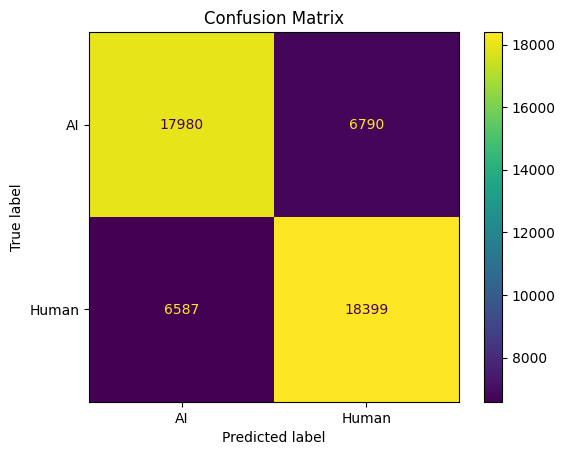


Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73     24770
           1       0.73      0.74      0.73     24986

    accuracy                           0.73     49756
   macro avg       0.73      0.73      0.73     49756
weighted avg       0.73      0.73      0.73     49756


Additional Metrics:
Accuracy: 0.73
F1-score: 0.73
True Positive Rate (TPR, Sensitivity): 0.74
True Negative Rate (TNR, Specificity): 0.73
False Positive Rate (FPR): 0.27
False Negative Rate (FNR): 0.26

Total Number of Mistakes: 13377
Error Rate: 0.27

TESTING DATASET


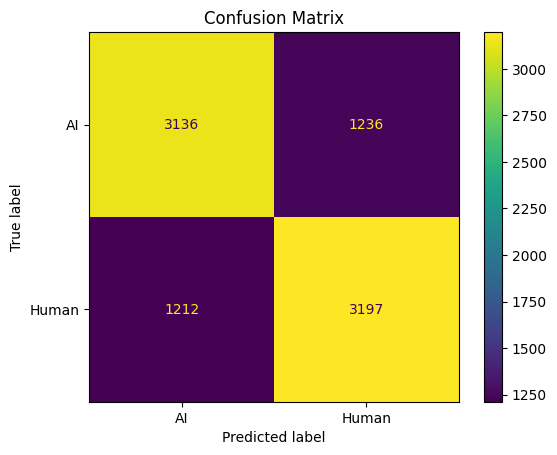


Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72      4372
           1       0.72      0.73      0.72      4409

    accuracy                           0.72      8781
   macro avg       0.72      0.72      0.72      8781
weighted avg       0.72      0.72      0.72      8781


Additional Metrics:
Accuracy: 0.72
F1-score: 0.72
True Positive Rate (TPR, Sensitivity): 0.73
True Negative Rate (TNR, Specificity): 0.72
False Positive Rate (FPR): 0.28
False Negative Rate (FNR): 0.27

Total Number of Mistakes: 2448
Error Rate: 0.28


In [124]:
evaluation(X_train, y_train, X_test, y_test, best_model)

# Naive Bayes 

In [77]:
from sklearn.naive_bayes import GaussianNB

In [93]:
pipeline_gaussian_NB = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('pca', PCA()),
    ('gaussian_NB', GaussianNB())# Apply PCA with 2 components
])

In [94]:
pipeline_gaussian_NB.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('gaussian_NB', GaussianNB())])

TRAINING DATASET


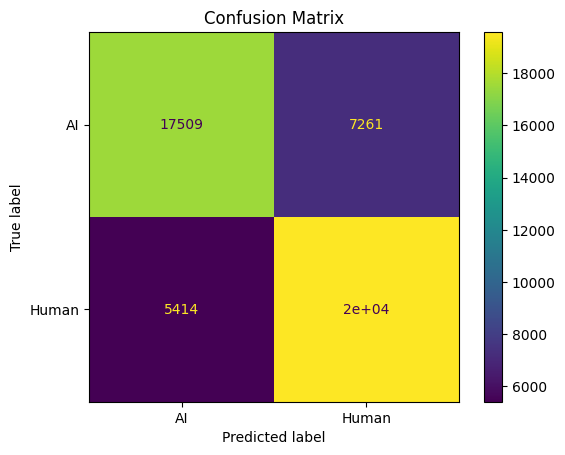


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73     24770
           1       0.73      0.78      0.76     24986

    accuracy                           0.75     49756
   macro avg       0.75      0.75      0.74     49756
weighted avg       0.75      0.75      0.74     49756


Additional Metrics:
Accuracy: 0.75
F1-score: 0.76
True Positive Rate (TPR, Sensitivity): 0.78
True Negative Rate (TNR, Specificity): 0.71
False Positive Rate (FPR): 0.29
False Negative Rate (FNR): 0.22

Total Number of Mistakes: 12675
Error Rate: 0.25

TESTING DATASET


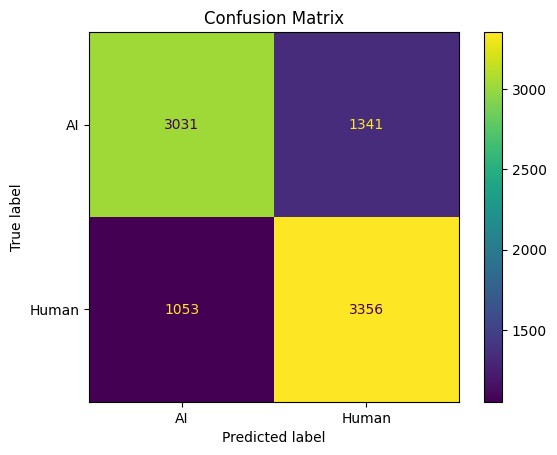


Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.69      0.72      4372
           1       0.71      0.76      0.74      4409

    accuracy                           0.73      8781
   macro avg       0.73      0.73      0.73      8781
weighted avg       0.73      0.73      0.73      8781


Additional Metrics:
Accuracy: 0.73
F1-score: 0.74
True Positive Rate (TPR, Sensitivity): 0.76
True Negative Rate (TNR, Specificity): 0.69
False Positive Rate (FPR): 0.31
False Negative Rate (FNR): 0.24

Total Number of Mistakes: 2394
Error Rate: 0.27


In [95]:
evaluation(X_train, y_train, X_test, y_test, pipeline_gaussian_NB)

# Support Vector Machine

In [96]:
from sklearn.svm import SVC

In [97]:
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('pca', PCA()),
    ('svc', SVC())# Apply PCA with 2 components
])

In [98]:
pipeline_svm.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('svc', SVC())])

TRAINING DATASET


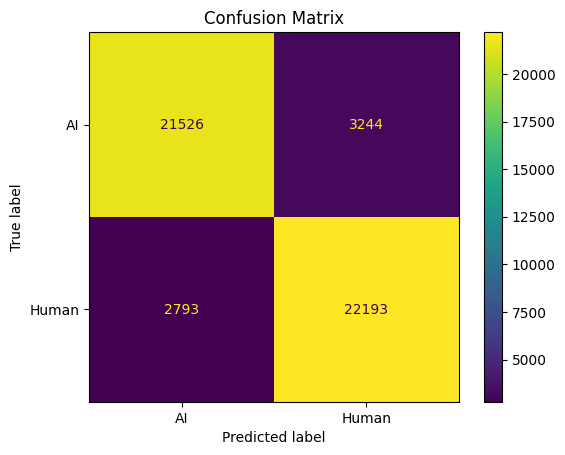


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88     24770
           1       0.87      0.89      0.88     24986

    accuracy                           0.88     49756
   macro avg       0.88      0.88      0.88     49756
weighted avg       0.88      0.88      0.88     49756


Additional Metrics:
Accuracy: 0.88
F1-score: 0.88
True Positive Rate (TPR, Sensitivity): 0.89
True Negative Rate (TNR, Specificity): 0.87
False Positive Rate (FPR): 0.13
False Negative Rate (FNR): 0.11

Total Number of Mistakes: 6037
Error Rate: 0.12

TESTING DATASET


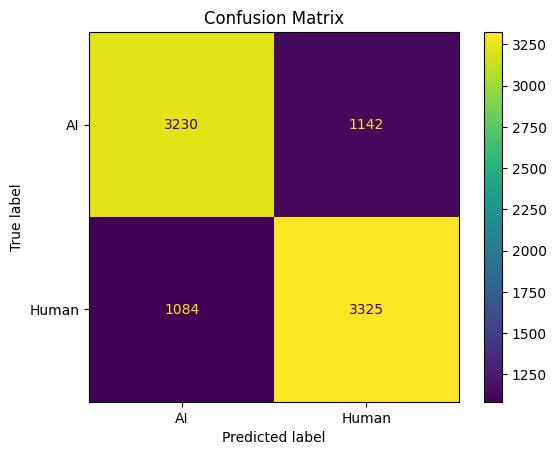


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.74      0.74      4372
           1       0.74      0.75      0.75      4409

    accuracy                           0.75      8781
   macro avg       0.75      0.75      0.75      8781
weighted avg       0.75      0.75      0.75      8781


Additional Metrics:
Accuracy: 0.75
F1-score: 0.75
True Positive Rate (TPR, Sensitivity): 0.75
True Negative Rate (TNR, Specificity): 0.74
False Positive Rate (FPR): 0.26
False Negative Rate (FNR): 0.25

Total Number of Mistakes: 2226
Error Rate: 0.25


In [99]:
evaluation(X_train, y_train, X_test, y_test, pipeline_svm)

In [101]:
joblib.dump(pipeline_svm, 'pipeline_svm.joblib')

['pipeline_svm.joblib']

# Random Forest Model

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
# from sklearn.model_selection import cross_val_score

In [7]:
# from skopt import BayesSearchCV
# from skopt.space import Real, Integer

In [20]:
pipeline_random_forest_classifier = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('pca', PCA()),
    ('random_forest', RandomForestClassifier())# Apply PCA with 2 components
])

In [21]:
# param_dist = {
#     'n_estimators': randint(low=50, high=200),
#     'max_depth': randint(low=1, high=10),
#     'min_samples_split': randint(low=2, high=20),
#     'min_samples_leaf': randint(low=1, high=10),
#     'max_features': ['sqrt', 'log2', None],
#     'bootstrap': [True, False]
# }
param_dist = {
    'random_forest__n_estimators': [50, 100, 150, 180, 200, 250, 300],
    'random_forest__max_depth': [10, 15, 20, 25, 30, 35],
    'random_forest__min_samples_split': [2, 5, 10, 15],
    'random_forest__min_samples_leaf': [1, 2, 5],
    'random_forest__max_features': ['sqrt', 'log2', None],
    'random_forest__bootstrap': [True, False],
    'random_forest__criterion' : ['gini', 'entropy', 'log_loss']
}

In [22]:
random_search_rf = RandomizedSearchCV(
    estimator=pipeline_random_forest_classifier,
    param_distributions=param_dist,
    n_iter=1,  # Number of parameter settings that are tried
    cv=5,  # Number of cross-validation folds
    verbose=2,
    random_state=42
)

In [23]:
random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END random_forest__bootstrap=False, random_forest__criterion=entropy, random_forest__max_depth=30, random_forest__max_features=None, random_forest__min_samples_leaf=2, random_forest__min_samples_split=10, random_forest__n_estimators=200; total time= 3.5min
[CV] END random_forest__bootstrap=False, random_forest__criterion=entropy, random_forest__max_depth=30, random_forest__max_features=None, random_forest__min_samples_leaf=2, random_forest__min_samples_split=10, random_forest__n_estimators=200; total time= 2.7min
[CV] END random_forest__bootstrap=False, random_forest__criterion=entropy, random_forest__max_depth=30, random_forest__max_features=None, random_forest__min_samples_leaf=2, random_forest__min_samples_split=10, random_forest__n_estimators=200; total time= 2.7min
[CV] END random_forest__bootstrap=False, random_forest__criterion=entropy, random_forest__max_depth=30, random_forest__max_features=None, random_forest__mi

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('random_forest',
                                              RandomForestClassifier())]),
                   n_iter=1,
                   param_distributions={'random_forest__bootstrap': [True,
                                                                     False],
                                        'random_forest__criterion': ['gini',
                                                                     'entropy',
                                                                     'log_loss'],
                                        'random_forest__max_depth': [10, 15, 20,
                                                                     25, 30,
                                                                     35],
                                        'random_forest__max_features': ['sqrt',
                                                                        'log2',
                                                                        None],
                                        'random_forest__min_samples_leaf': [1,
                                                                            2,
                                                                            5],
                                        'random_forest__min_samples_split': [2,
                                                                             5,
                                                                             10,
                                                                             15],
                                        'random_forest__n_estimators': [50, 100,
                                                                        150,
                                                                        180,
                                                                        200,
                                                                        250,
                                                                        300]},
                   random_state=42, verbose=2)

In [ ]:
print("Best Hyperparameters:", random_search_rf.best_params_)

In [136]:
pipeline_random_forest_classifier.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('random_forest', RandomForestClassifier())])

TRAINING DATASET


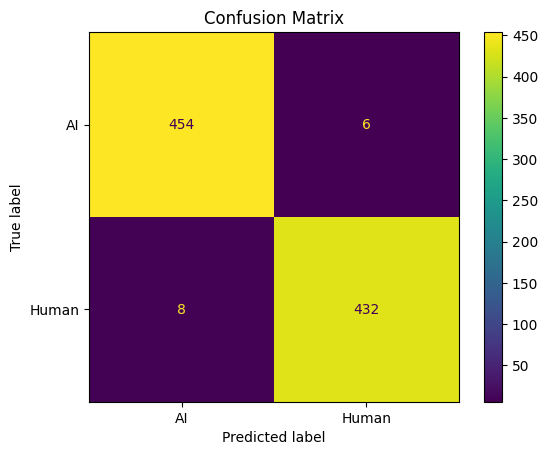


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       460
           1       0.99      0.98      0.98       440

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900


Additional Metrics:
Accuracy: 0.98
F1-score: 0.98
True Positive Rate (TPR, Sensitivity): 0.98
True Negative Rate (TNR, Specificity): 0.99
False Positive Rate (FPR): 0.01
False Negative Rate (FNR): 0.02

Total Number of Mistakes: 14
Error Rate: 0.02

TESTING DATASET


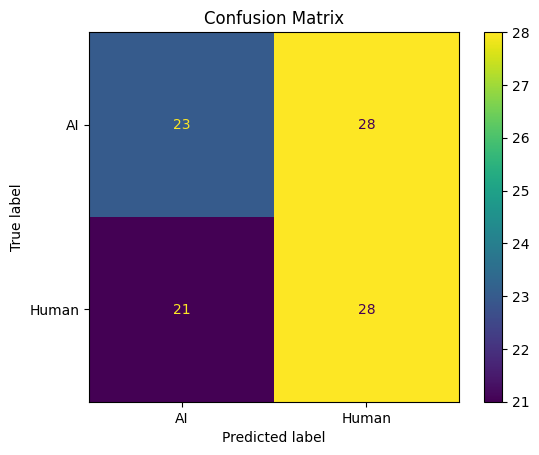


Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.45      0.48        51
           1       0.50      0.57      0.53        49

    accuracy                           0.51       100
   macro avg       0.51      0.51      0.51       100
weighted avg       0.51      0.51      0.51       100


Additional Metrics:
Accuracy: 0.51
F1-score: 0.53
True Positive Rate (TPR, Sensitivity): 0.57
True Negative Rate (TNR, Specificity): 0.45
False Positive Rate (FPR): 0.55
False Negative Rate (FNR): 0.43

Total Number of Mistakes: 49
Error Rate: 0.49


In [29]:
evaluation(X_train, y_train, X_test, y_test, random_search_rf)

In [43]:
param_space = {
    'n_estimators': Integer(50, 250),
    'max_depth': Integer(10, 70),
    'min_samples_split': Integer(2, 20),
    'criterion' : ('gini', 'entropy', 'log_loss')
}

In [24]:
bayes_search = BayesSearchCV(
    estimator=random_forest_classifier,
    search_spaces=param_space,
    n_iter=1,                  
    cv=5,                       
    scoring='accuracy',         
    random_state=42,
    verbose = 1
)


In [ ]:
bayes_search.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [179]:
cv_results = pd.DataFrame(bayes_search.cv_results_)

In [180]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.580787,0.145036,0.015399,0.001358,entropy,50,20,100,"{'criterion': 'entropy', 'max_depth': 50, 'min...",0.82500,0.85625,0.84375,0.84375,0.81250,0.83625,0.015512,15
1,6.756424,0.286201,0.039188,0.005033,log_loss,70,2,250,"{'criterion': 'log_loss', 'max_depth': 70, 'mi...",0.81875,0.85625,0.86875,0.81875,0.80000,0.83250,0.025739,17
2,4.273878,0.312250,0.023393,0.001959,entropy,70,2,150,"{'criterion': 'entropy', 'max_depth': 70, 'min...",0.81875,0.84375,0.87500,0.80000,0.85000,0.83750,0.025921,14
3,6.530433,0.256340,0.035178,0.001466,log_loss,10,10,250,"{'criterion': 'log_loss', 'max_depth': 10, 'mi...",0.84375,0.85000,0.88125,0.83125,0.82500,0.84625,0.019605,5
4,5.303402,0.162794,0.030587,0.004119,log_loss,25,10,200,"{'criterion': 'log_loss', 'max_depth': 25, 'mi...",0.82500,0.86250,0.85625,0.83750,0.82500,0.84125,0.015612,9
5,1.268390,0.012591,0.008198,0.000748,log_loss,70,2,50,"{'criterion': 'log_loss', 'max_depth': 70, 'mi...",0.81250,0.81250,0.81875,0.81875,0.83750,0.82000,0.009186,24
6,6.656054,0.266005,0.035189,0.002322,entropy,70,10,250,"{'criterion': 'entropy', 'max_depth': 70, 'min...",0.85000,0.86875,0.89375,0.82500,0.84375,0.85625,0.023385,1
7,6.484534,0.125587,0.040384,0.011017,entropy,70,10,250,"{'criterion': 'entropy', 'max_depth': 70, 'min...",0.83750,0.85625,0.85625,0.81875,0.83125,0.84000,0.014577,12
8,3.836771,0.351215,0.022989,0.003623,log_loss,50,20,150,"{'criterion': 'log_loss', 'max_depth': 50, 'mi...",0.84375,0.86875,0.86875,0.82500,0.81250,0.84375,0.022707,6
9,2.201889,0.017471,0.015196,0.000400,gini,70,20,100,"{'criterion': 'gini', 'max_depth': 70, 'min_sa...",0.84375,0.83750,0.84375,0.79375,0.81250,0.82625,0.019922,22


In [178]:
print("val. score: ", bayes_search.best_score_)
print("test score: ", bayes_search.score(X_test, y_test))
print("best params: ", bayes_search.best_params_)

val. score:  0.85625
test score:  0.835
best params:  OrderedDict([('criterion', 'entropy'), ('max_depth', 70), ('min_samples_split', 10), ('n_estimators', 250)])


In [181]:
y_pred_test = bayes_search.predict(X_test)

In [134]:
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150)

In [ ]:
y_pred_test = bayes_search.predict(X_test_transformed)
y_pred_train = bayes_search.predict(X_train_transformed)

# XGBoost 

In [138]:
from xgboost import XGBClassifier
# from skopt import BayesSearchCV
# from skopt.space import Real, Integer

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
pipeline_xgboost = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('pca', PCA()),
    ('xgboost_classifier', XGBClassifier())# Apply PCA with 2 components
])

In [141]:
pipeline_xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

TRAINING DATASET


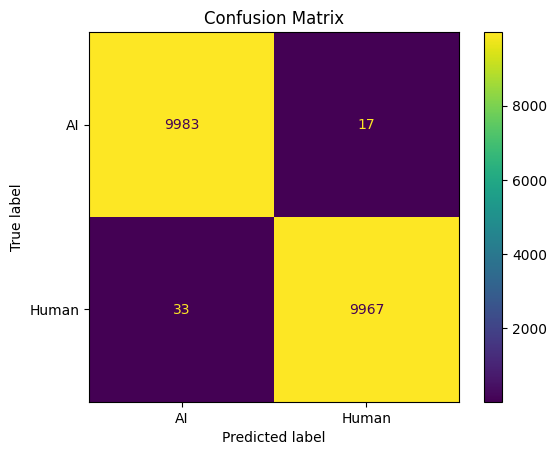


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


Additional Metrics:
Accuracy: 1.00
F1-score: 1.00
True Positive Rate (TPR, Sensitivity): 1.00
True Negative Rate (TNR, Specificity): 1.00
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 0.00

Total Number of Mistakes: 50
Error Rate: 0.00

TESTING DATASET


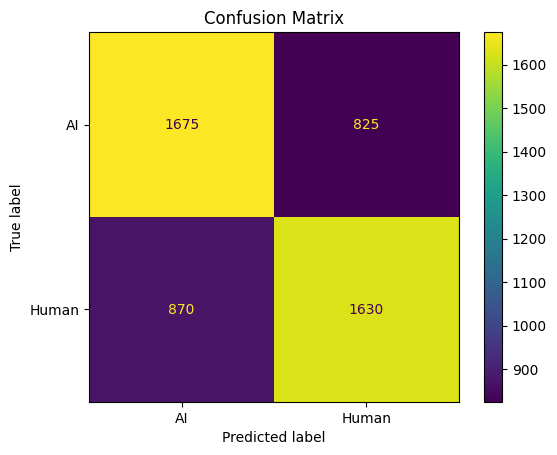


Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.66      2500
           1       0.66      0.65      0.66      2500

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.66      0.66      0.66      5000


Additional Metrics:
Accuracy: 0.66
F1-score: 0.66
True Positive Rate (TPR, Sensitivity): 0.65
True Negative Rate (TNR, Specificity): 0.67
False Positive Rate (FPR): 0.33
False Negative Rate (FNR): 0.35

Total Number of Mistakes: 1695
Error Rate: 0.34


In [142]:
evaluation(X_train, y_train, X_test, y_test, pipeline_xgboost)

In [134]:
# Define the parameter search space
search_spaces = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(2, 10),
    'learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.3, 1.0),
    'gamma': Real(0, 0.5),
    'reg_alpha': Real(0, 1.0),
    'reg_lambda': Real(0, 1.0),
    'min_child_weight': Integer(1, 10),
    
}

# Set up the BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=xgboost_classifier,
    search_spaces=search_spaces,
    scoring='accuracy', 
    cv=5,
    n_iter=25,  
    verbose=0,
    random_state=42
)

# Fit to the training data
bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=200, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0, high=1.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=1.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1.0, prior='uniform', transform='normalize')})

In [217]:
print("val. score: ", bayes_search.best_score_) #10 iter
print("test score: ", bayes_search.score(X_test, y_test)) 
print("best params: ", bayes_search.best_params_)

val. score:  0.85375
test score:  0.865
best params:  OrderedDict([('colsample_bytree', 0.8596874091250211), ('gamma', 0.21901459322046168), ('learning_rate', 0.05996280567850356), ('max_depth', 8), ('min_child_weight', 9), ('n_estimators', 158), ('reg_alpha', 0.42417807246068207), ('reg_lambda', 0.6502841017477626), ('subsample', 0.7412335382111885)])


In [219]:
print("val. score: ", bayes_search.best_score_) #25 iter
print("test score: ", bayes_search.score(X_test, y_test))
print("best params: ", bayes_search.best_params_)

val. score:  0.865
test score:  0.875
best params:  OrderedDict([('colsample_bytree', 0.7098159680567573), ('gamma', 0.4325903537768684), ('learning_rate', 0.11911146809554733), ('max_depth', 10), ('min_child_weight', 4), ('n_estimators', 200), ('reg_alpha', 0.19045293322755044), ('reg_lambda', 1.0), ('subsample', 0.8851384179544988)])


In [221]:
print("val. score: ", bayes_search.best_score_) #60 iter
print("test score: ", bayes_search.score(X_test, y_test))
print("best params: ", bayes_search.best_params_)

val. score:  0.8675
test score:  0.84
best params:  OrderedDict([('colsample_bytree', 0.7598166505204225), ('gamma', 0.5), ('learning_rate', 0.08580281705462359), ('max_depth', 3), ('min_child_weight', 10), ('n_estimators', 200), ('reg_alpha', 0.0), ('reg_lambda', 0.0), ('subsample', 1.0)])


In [135]:
print("val. score: ", bayes_search.best_score_) #25 iter
print("test score: ", bayes_search.score(X_test, y_test)) 
print("best params: ", bayes_search.best_params_)

val. score:  0.9037499999999999
test score:  0.9135
best params:  OrderedDict([('colsample_bytree', 0.9981051707664326), ('gamma', 0.469819076944712), ('learning_rate', 0.14652183363667018), ('max_depth', 10), ('min_child_weight', 10), ('n_estimators', 200), ('reg_alpha', 0.8999343276827675), ('reg_lambda', 0.07026580469678426), ('subsample', 0.6524891243612454)])


In [136]:
best_model = bayes_search.best_estimator_
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9981051707664326, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.469819076944712,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14652183363667018,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [138]:
best_model.score(X_train, y_train)

0.999625

# MLP Classifier

In [143]:
from sklearn.neural_network import MLPClassifier

In [144]:
mlp_classifier = MLPClassifier(hidden_layer_sizes = (1000, 500), 
                               max_iter=5, 
                               random_state=1,
                               verbose = 1,
                              )

In [145]:
mlp_classifier.fit(preprocessed_X_train_std, y_train)

Iteration 1, loss = 0.58413824
Iteration 2, loss = 0.45328284
Iteration 3, loss = 0.37874697
Iteration 4, loss = 0.31345903
Iteration 5, loss = 0.23749715


C:\Users\HP\anaconda3\envs\MyProject\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(1000, 500), max_iter=5, random_state=1,
              verbose=1)

TRAINING DATASET


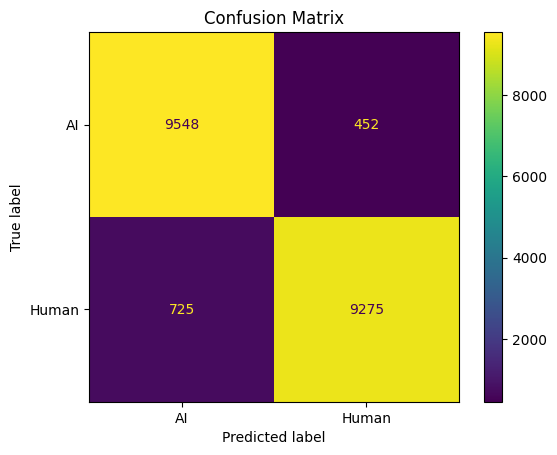


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94     10000
           1       0.95      0.93      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000


Additional Metrics:
Accuracy: 0.94
F1-score: 0.94
True Positive Rate (TPR, Sensitivity): 0.93
True Negative Rate (TNR, Specificity): 0.95
False Positive Rate (FPR): 0.05
False Negative Rate (FNR): 0.07

Total Number of Mistakes: 1177
Error Rate: 0.06

TESTING DATASET


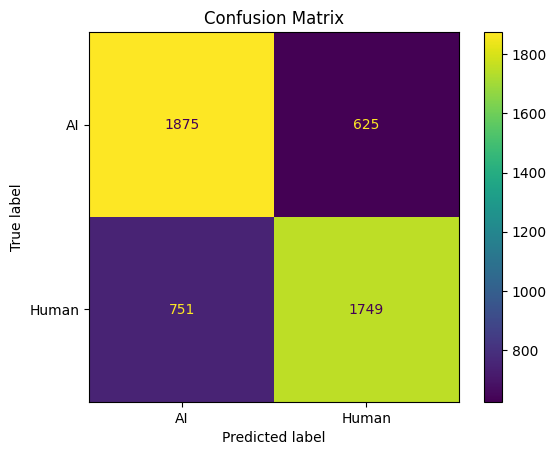


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73      2500
           1       0.74      0.70      0.72      2500

    accuracy                           0.72      5000
   macro avg       0.73      0.72      0.72      5000
weighted avg       0.73      0.72      0.72      5000


Additional Metrics:
Accuracy: 0.72
F1-score: 0.72
True Positive Rate (TPR, Sensitivity): 0.70
True Negative Rate (TNR, Specificity): 0.75
False Positive Rate (FPR): 0.25
False Negative Rate (FNR): 0.30

Total Number of Mistakes: 1376
Error Rate: 0.28


In [146]:
evaluation(preprocessed_X_train_std, y_train, preprocessed_X_test_std, y_test, mlp_classifier)

# Explainable AI using LIME

In [60]:
import lime

In [61]:
# Create a LIME text explainer
from lime.lime_text import LimeTextExplainer

class_names = ["human", "AI"]  # 1 for AI and 0 for Human
explainer = LimeTextExplainer(class_names=class_names)

In [85]:
#Custome Testing!

X_test_new = '''World War II, which lasted from 1939 to 1945, was one of the most significant and devastating
conflicts in human history, involving the vast majority of the world's nations, including all of the
great powers, eventually forming two opposing military alliances: the Allies and the Axis. The
war began on September 1, 1939, when Germany, under the leadership of Adolf Hitler, invaded
Poland. This act prompted Britain and France to declare war on Germany. The conflict soon
expanded as Germany, Italy, and Japan sought territorial expansion, leading to widespread
global conflict.
In Europe, Germany's blitzkrieg tactics led to the rapid conquest of several countries. France fell
in 1940, and Britain endured the prolonged Battle of Britain, successfully resisting German air
assaults. Meanwhile, in Eastern Europe, Germany invaded the Soviet Union in 1941, initiating a
brutal and prolonged conflict on the Eastern Front. The war in the Pacific was marked by the
Japanese attack on Pearl Harbor on December 7, 1941, which led to the United States entering
the war. The Pacific theater saw fierce battles across numerous islands, with significant naval
engagements such as the Battle of Midway in 1942, which marked a turning point in favor of the
Allies.
The Holocaust, the systematic genocide of six million Jews and millions of other minorities by
Nazi Germany, remains one of the most horrific aspects of World War II. The war also saw
significant advances in technology and warfare, including the development and use of tanks,
aircraft, and eventually nuclear weapons. The Allied invasion of Normandy on June 6, 1944,
known as D-Day, was a pivotal moment that led to the liberation of Western Europe from Nazi
control. The war in Europe ended on May 8, 1945, with the unconditional surrender of Germany.
In the Pacific, the war continued until August 1945, culminating in the United States dropping
atomic bombs on the Japanese cities of Hiroshima and Nagasaki, leading to Japan's surrender
on September 2, 1945.
World War II resulted in an estimated 70-85 million fatalities, making it the deadliest conflict in
human history. The war caused widespread destruction and significant shifts in political power,
leading to the emergence of the United States and the Soviet Union as superpowers and the
beginning of the Cold War. The United Nations was established in the aftermath to promote
international cooperation and prevent future conflicts. The war's legacy continues to influence
global politics, economics, and society, underscoring the profound impact of this monumental
period in history'''



In [83]:
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('svc', LogisticRegression())
])

In [87]:
lr_pipeline.fit(dataset_25000['text'], dataset_25000['label'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svc', LogisticRegression())])

In [88]:
# X_test_new = np.array(X_test_new).reshape(1,-1)

In [89]:
# X_test_new_transformed = tfidf_vectorizer.transform(X_test_new)

In [90]:
# X_test_new_transformed.shape

In [102]:
# Explain the prediction for the selected instance
exp = explainer.explain_instance(X_test_new, lr_pipeline.predict_proba, num_features=10)
# exp = explainer.explain_instance(X_test_new, pipeline.predict_proba, num_features=10)

In [93]:
# Get the prediction probability
prediction_prob = lr_pipeline.predict_proba([X_test_new])

print(prediction_prob)

[[0.40048317 0.59951683]]


In [97]:
lr_pipeline.predict([X_test_new])

array([1], dtype=int64)

In [103]:
# Print and visualize the explanation

exp.show_in_notebook()


In [104]:


# Print the LIME values sorted by importance
sorted_explanation = sorted(exp.as_list(), key=lambda x: abs(x[1]), reverse=True)
print("Top features contributing to the prediction:")
for feature, importance in sorted_explanation:
    print(f"Feature: {feature}, Importance: {importance}")

# Optional: print top 10 features
print("\nTop 10 features contributing to the prediction:")
for feature, importance in sorted_explanation[:10]:
    print(f"Feature: {feature}, Importance: {importance}")

Top features contributing to the prediction:
Feature: of, Importance: -0.20560687739660777
Feature: in, Importance: -0.1515805923126133
Feature: significant, Importance: 0.1275694006024661
Feature: on, Importance: -0.060165887609691646
Feature: which, Importance: 0.03931402086709174
Feature: leading, Importance: 0.03586634211930258
Feature: led, Importance: 0.033753474021439564
Feature: United, Importance: -0.028080516937477002
Feature: including, Importance: 0.026712836108336663
Feature: to, Importance: 0.025824802467523642

Top 10 features contributing to the prediction:
Feature: of, Importance: -0.20560687739660777
Feature: in, Importance: -0.1515805923126133
Feature: significant, Importance: 0.1275694006024661
Feature: on, Importance: -0.060165887609691646
Feature: which, Importance: 0.03931402086709174
Feature: leading, Importance: 0.03586634211930258
Feature: led, Importance: 0.033753474021439564
Feature: United, Importance: -0.028080516937477002
Feature: including, Importance: 0